#Modis data and NDVI, EVI of protected areaa

In [ ]:
# installing everything
!pip install earthengine-api
!pip install folium 
!pip install geehydro
!pip install ipygee
!pip install proplot

# Importing

In [ ]:
import ee 
import folium
import geehydro
import numpy as np
import pandas as pd
import proplot as plot 
import matplotlib.pyplot as plt 

from ipygee import *
from pandas.plotting import register_matplotlib_converters

/usr/local/lib/python3.8/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


# Authentication

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=980aeqonhCHyzjAzT6zwo300KLMoaFmFHrAlx2oIPTc&tc=Jlfa0NPiSCkTgXfnD_wW4pYqPWbR0eCEePxQJuPdEXE&cc=kCb3f004B0rUTye19rDZeBitulBQA48RxVsXdO3iVTQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWgavdcgf0YwgXLHlvoHsyJopFCQ4ZWY1yzu4XkaYBrOiC-2oVWH_-fl-pc

Successfully saved authorization token.


# World Database on Protected Areas (WDPA)

In [ ]:
wdpa_polygon = ee.FeatureCollection('WCMC/WDPA/current/polygons')
# select the Xingu Indigenous Park 
xingu = wdpa_polygon.filter(ee.Filter.eq('NAME', 'Hallasan')) 
Korea=wdpa_polygon.filter(ee.Filter.eq('SUB_LOC', 'KR'))
Hallasan= xingu = wdpa_polygon.filter(ee.Filter.eq('NAME', 'Hallasan'))

In [ ]:
wdpa_polygon.size().getInfo()
wdpa_polygon.first().getInfo()
Hallasan.getInfo()


In [ ]:
Hallasan.getInfo()

In [ ]:
Map = folium.Map(location=[33, 126], zoom_start=8)
#Map.setOptions('HYBRID')
Map.addLayer(Hallasan)
Map

# MODIS MOD13Q1 Vegetation Indices

In [ ]:
# MODIS MOD13Q1
modis = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(ee.DateRange('2015-01-01',
                                                                        '2019-12-31'))

In [ ]:
# select EVI and NDVI
evi = modis.select('EVI')
ndvi = modis.select('NDVI')

In [ ]:
def scale_factor(image):
  # scale factor for the MODIS MOD13Q1 product
  return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

In [ ]:
# mapping function to multiply by the scale factor
scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [ ]:
Map.addLayer(scaled_ndvi.mean().clip(Hallasan),
             vis_params={'min': 0,
                         'max': 1,
                         'palette': ['red', 'green', 'blue']})
Map

In [ ]:
Hallasan_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                                   'region': Hallasan,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 500,
                                   'xProperty': 'system:time_start'
                                  })
Hallasan_ndvi.renderWidget(width='50%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [ ]:
type(Hallasan_ndvi.dataframe)

pandas.core.frame.DataFrame

In [ ]:
Hallasan_evi = chart.Image.series(**{'imageCollection': scaled_evi,
                                   'region': Hallasan,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start',
                                   'title': 'Average Vegetation Index Value by Date'})
 
Hallasan_evi.renderWidget(width='75%')


HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [ ]:
help(chart.Image.series)

Help on function series in module ipygee.chart:

series(imageCollection, region, reducer='mean', scale=None, xProperty='system:time_start', bands=None, label_bands=None, properties=None, label_properties=None, **kwargs)
    Basic plot over an ImageCollection
    
    :param region: the region to reduce over an get a (unique) value
    :type region: ee.Geometry or ee.Feature or ee.FeatureCollection
    :param reducer: the reducer to apply over the region.
    :param scale: the scale to apply the reducer. If None, will use the
        nominal scale of the first band of the first image of the
        collection
    :param xProperty: the property that will be use for the x axis
    :param bands: the bands that will be used for the y axis
    :param label_bands: the names for the series of bands. Have to match
        the length of bands
    :param properties: the properties that will be used for the y axis
    :param label_properties: the names for the series of properties. Have
        to

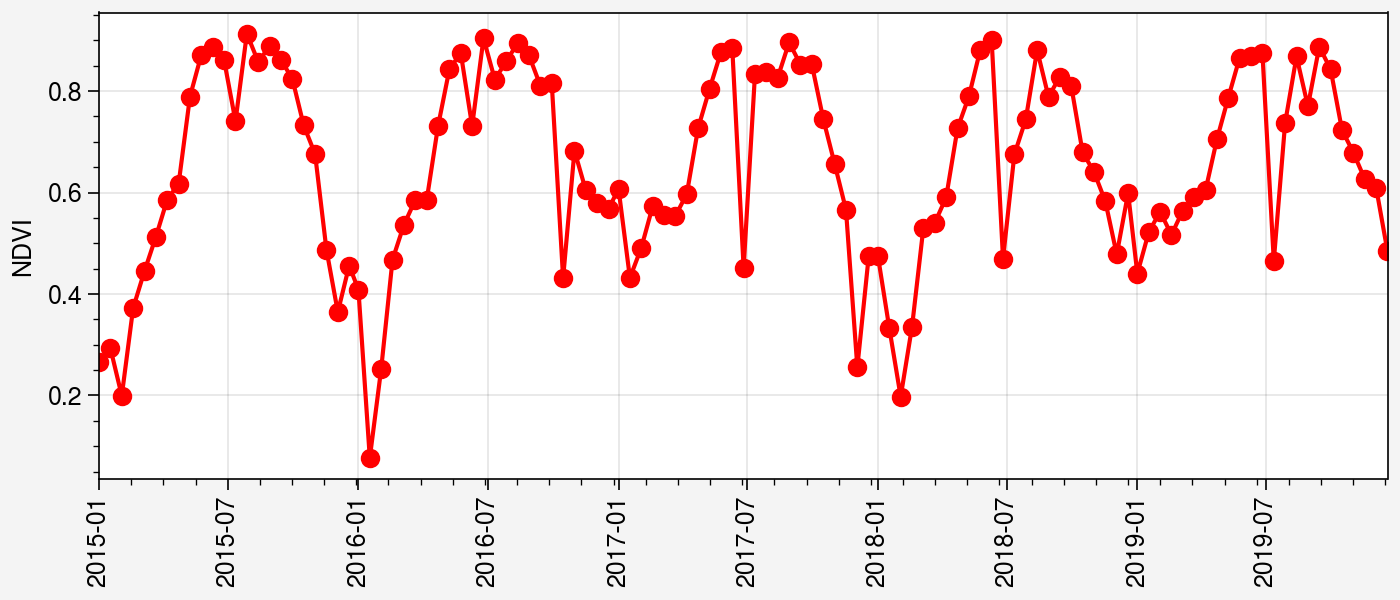

In [ ]:
fig, ax = plot.subplots(figsize=(7, 3), tight=True)
ax.plot(Hallasan_ndvi.dataframe.index, Hallasan_ndvi.dataframe['NDVI'],
        color='Red', marker='o')
plot.show()

In [ ]:
Hallasan_evi_monthly = Hallasan_evi.dataframe.groupby(pd.Grouper(freq="M")).mean()
Hallasan_ndvi_monthly = Hallasan_ndvi.dataframe.groupby(pd.Grouper(freq="M")).mean()

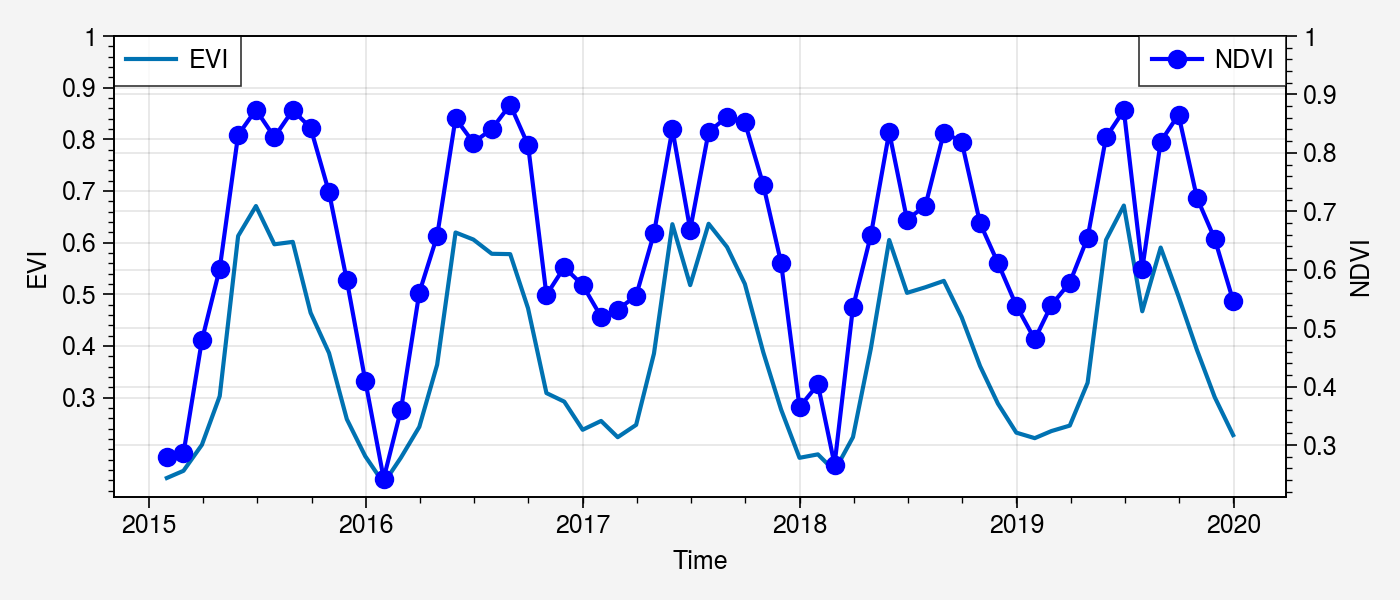

In [ ]:
time = Hallasan_evi_monthly.index
fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()

ax1.plot(Hallasan_evi_monthly, label='EVI')
ax2.plot( Hallasan_ndvi_monthly, label='NDVI',
         color='blue', marker='o')

ax1.set_xlabel('Time')
ax1.set_ylabel('EVI')
ax2.set_ylabel('NDVI')

ax1.set_yticks(np.arange(0.3, 1.1, 0.1))
ax2.set_yticks(np.arange(0.3, 1.1, 0.1))

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()